In [5]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import itertools

## Initialization

### Load Dataset

In [6]:
def loadImages(dirName):
    data = []
    label = []
    for root, dirs, files in os.walk(dirName):
        for file in files:
            # Load image from a path
            face = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
            # Flatten image . Note: size of any image is 256,256
            face = face.reshape(256 * 256, ).tolist()
            data.append(face)
             # Label of an image is in its fileName
            label.append(file.split('.')[1])
    return np.asarray(data) , np.asarray(label)

In [7]:
train_data , train_label = loadImages('FER2013/train')
test_data , test_label = loadImages('FER2013/test')

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

print(set(train_label))

(154, 65536) (154,)
(59, 65536) (59,)
{'angry', 'disgust', 'fear', 'happy', 'surprise', 'sad'}


### About Data

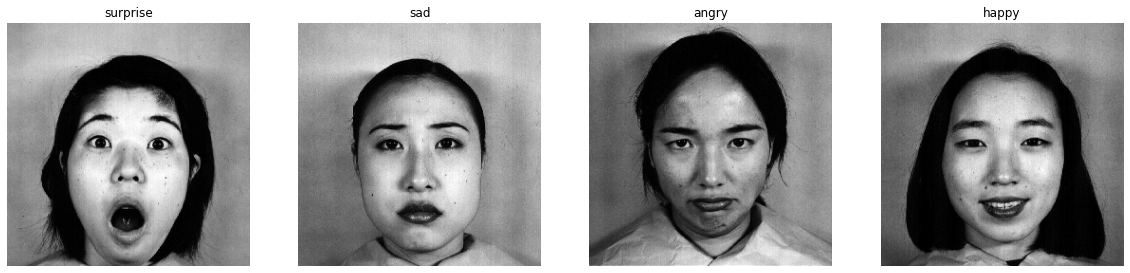

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

idxs = np.random.randint(0, train_data.shape[0], size=4)
for i, idx in enumerate(idxs):
    axs[i].set_title(train_label[idx])
    axs[i].imshow(train_data[idx].reshape(256,256), cmap='gray')
    axs[i].axis('off')

## Dimensionality Reduction with PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(random_state=123).fit(train_data)

print(pca.components_.shape)
print(pca.components_)

print(pca.explained_variance_.shape)
print(pca.explained_variance_)

(154, 65536)
[[ 0.0054336   0.00559236  0.0055649  ...  0.00122241  0.00130482
   0.00149479]
 [-0.00158406 -0.00136184 -0.0012749  ... -0.00061616 -0.00087385
  -0.00082845]
 [-0.00335762 -0.00317982 -0.00344016 ... -0.00409466 -0.00421453
  -0.00421477]
 ...
 [-0.00483374  0.00076893  0.00297993 ... -0.00312121  0.00184994
   0.00222964]
 [-0.00175734 -0.00034556  0.00223746 ... -0.00070846  0.0024596
  -0.0006304 ]
 [-0.06212063 -0.00139253 -0.00969885 ... -0.00277627  0.00366215
   0.00017118]]
(154,)
[1.99424101e+07 1.79141367e+07 1.31828932e+07 6.28819759e+06
 5.08060382e+06 3.92981232e+06 3.24408605e+06 2.67356197e+06
 2.13770030e+06 1.83777055e+06 1.61614250e+06 1.56363526e+06
 1.41347826e+06 1.25491089e+06 1.06475191e+06 8.90446626e+05
 8.17201674e+05 7.61155632e+05 7.21273508e+05 6.78062057e+05
 6.08067915e+05 5.93249800e+05 5.27423586e+05 5.08976750e+05
 4.69830872e+05 4.27869861e+05 4.20570073e+05 4.04832130e+05
 3.86986523e+05 3.65094362e+05 3.55002119e+05 3.40957833e+05
 

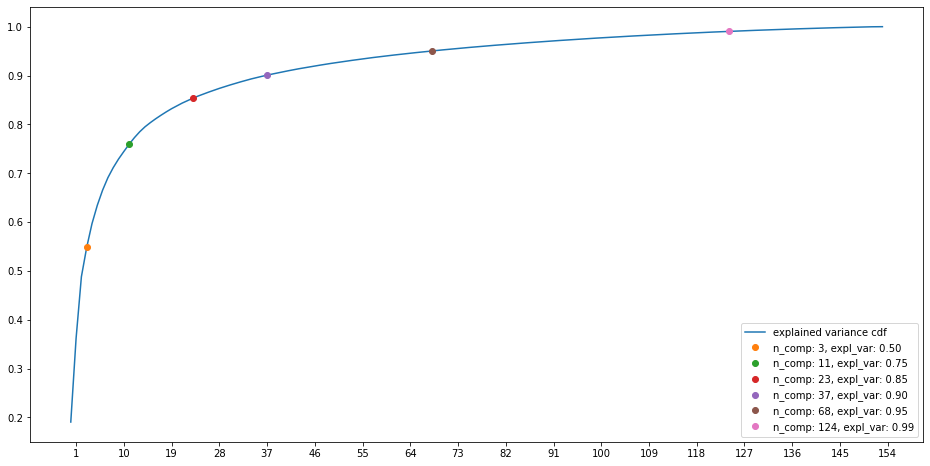

In [10]:
plt.figure(figsize=(16, 8))
cdf = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(cdf)), cdf, label='explained variance cdf')
plt.xticks(range(1, pca.components_.shape[0]+1, 9))

for limit in [0.5, 0.75, 0.85, 0.9, 0.95, 0.99]:
    idx = np.argmax(cdf>=limit)
    plt.plot(idx, cdf[idx], 'o', label='n_comp: %d, expl_var: %0.2f' % (idx, limit))

plt.legend()
plt.show()

## Eigenfaces

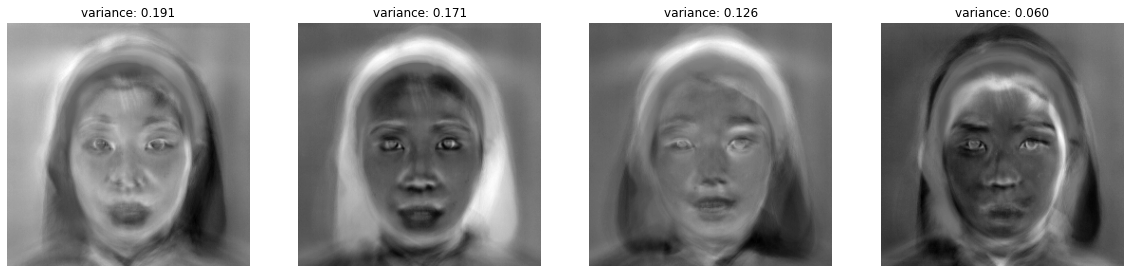

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i in range(4):
    axs[i].set_title('variance: %0.3f' % pca.explained_variance_ratio_[i])
    axs[i].imshow(pca.components_[i].reshape(256, 256), cmap='gray')
    axs[i].axis('off')

## Classification

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Classification without Dimensionality Reduction

#### 1NN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=1)

nn.fit(train_data, train_label)
predict = nn.predict(test_data)

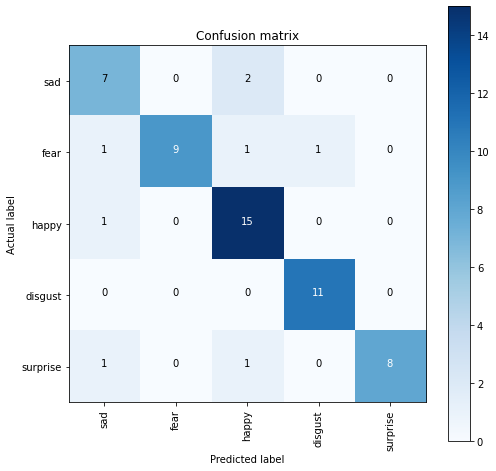

In [10]:
from sklearn.metrics import confusion_matrix

labels = list(set(test_label))
cm = confusion_matrix(test_label, predict, labels=labels)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, labels)

In [11]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(test_label, predict)
print('Accuracy: %0.3f' % total_acc)
print()

ccr = [cm[i, i] / cm[i, :].sum() for i in range(5)]
labels = list(set(test_label))
for i, l in enumerate(labels):
    print('CCR-%s: %0.3f' % (l, ccr[i]))

Accuracy: 0.847

CCR-sad: 0.778
CCR-fear: 0.750
CCR-happy: 0.938
CCR-disgust: 1.000
CCR-surprise: 0.800


#### 2NN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=2)

nn.fit(train_data, train_label)
predict = nn.predict(test_data)

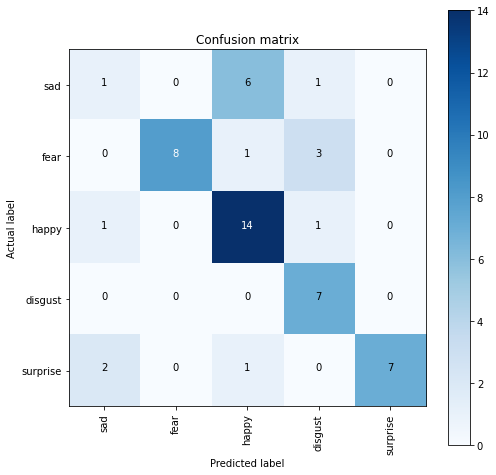

In [13]:
from sklearn.metrics import confusion_matrix

labels = list(set(test_label))
cm = confusion_matrix(test_label, predict, labels=labels)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, labels)

In [14]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(test_label, predict)
print('Accuracy: %0.2f' % total_acc)
print()

ccr = [cm[i, i] / cm[i, :].sum() for i in range(5)]
labels = list(set(test_label))
for i, l in enumerate(labels):
    print('CCR-%s: %0.2f' % (l, ccr[i]))

Accuracy: 0.63

CCR-sad: 0.12
CCR-fear: 0.67
CCR-happy: 0.88
CCR-disgust: 1.00
CCR-surprise: 0.70


### Classification with Dimensionality Reduction

#### 1NN

In [15]:
accs = []

components = range(1, 155, 5)
for n in components:
    pca = PCA(n_components=n, random_state=123).fit(train_data)
    
    train_data_trans = pca.transform(train_data)
    test_data_trans = pca.transform(test_data)
    
    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(train_data_trans, train_label)
    predict = nn.predict(test_data_trans)
    
    total_acc = accuracy_score(test_label, predict)
    accs.append(total_acc)

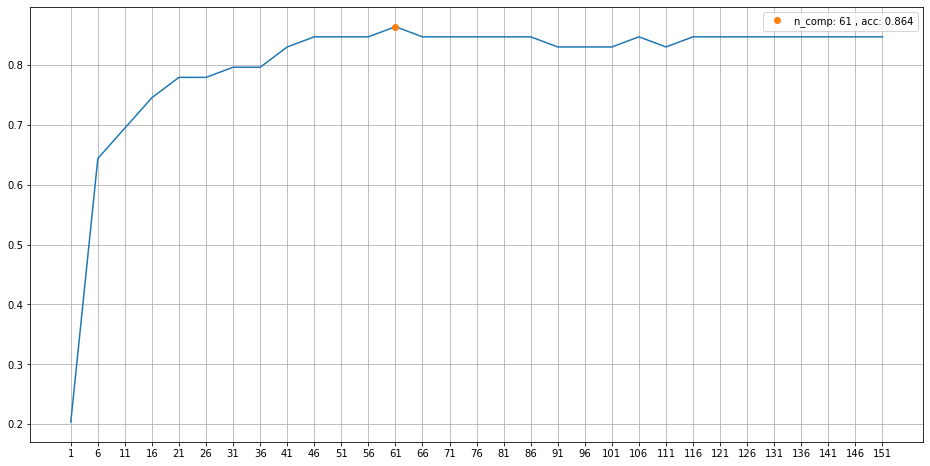

In [16]:
plt.figure(figsize=(16, 8))

plt.plot(components, accs)
plt.xticks(components)

idx = np.argmax(accs)
plt.plot(components[idx], accs[idx], 'o', label='n_comp: %d , acc: %0.3f' % (components[idx], accs[idx]))

plt.grid()
plt.legend()
plt.show()

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=components[idx], random_state=123).fit(train_data)

train_data_trans = pca.transform(train_data)
test_data_trans = pca.transform(test_data)

from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=1)

nn.fit(train_data_trans, train_label)
predict = nn.predict(test_data_trans)

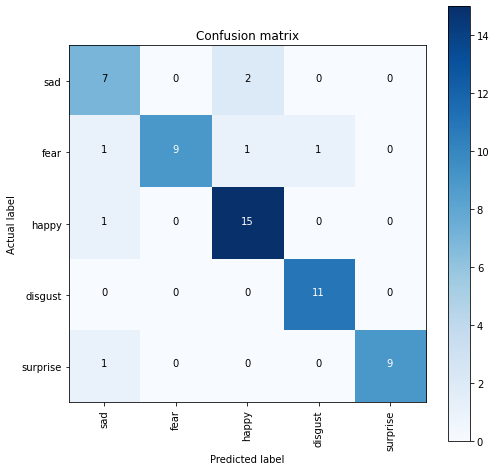

In [18]:
from sklearn.metrics import confusion_matrix

labels = list(set(test_label))
cm = confusion_matrix(test_label, predict, labels=labels)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, labels)

In [19]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(test_label, predict)
print('Accuracy: %0.3f' % total_acc)
print()

ccr = [cm[i, i] / cm[i, :].sum() for i in range(5)]
labels = list(set(test_label))
for i, l in enumerate(labels):
    print('CCR-%s: %0.3f' % (l, ccr[i]))

Accuracy: 0.864

CCR-sad: 0.778
CCR-fear: 0.750
CCR-happy: 0.938
CCR-disgust: 1.000
CCR-surprise: 0.900


#### 2NN

In [20]:
accs = []

components = range(1, 155, 5)
for n in components:
    pca = PCA(n_components=n, random_state=123).fit(train_data)
    
    train_data_trans = pca.transform(train_data)
    test_data_trans = pca.transform(test_data)
    
    nn = KNeighborsClassifier(n_neighbors=2)
    nn.fit(train_data_trans, train_label)
    predict = nn.predict(test_data_trans)
    
    total_acc = accuracy_score(test_label, predict)
    accs.append(total_acc)

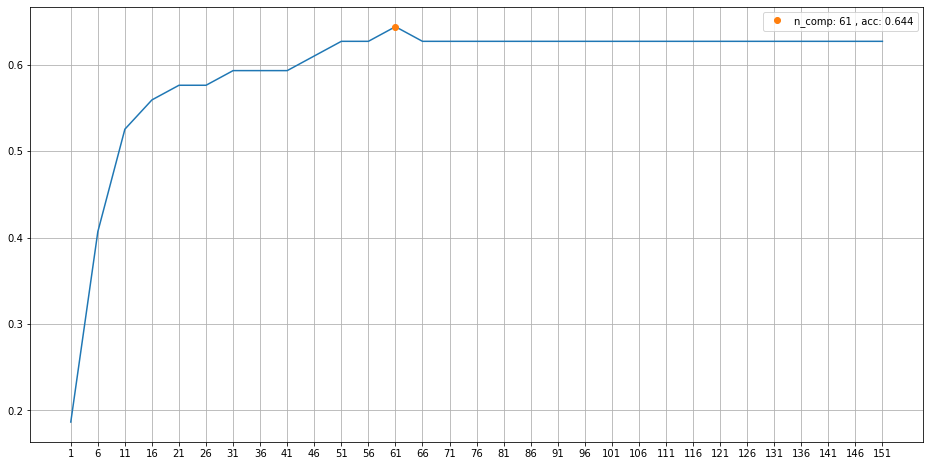

In [21]:
plt.figure(figsize=(16, 8))

plt.plot(components, accs)
plt.xticks(components)

idx = np.argmax(accs)
plt.plot(components[idx], accs[idx], 'o', label='n_comp: %d , acc: %0.3f' % (components[idx], accs[idx]))

plt.grid()
plt.legend()
plt.show()

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=components[idx], random_state=123).fit(train_data)

train_data_trans = pca.transform(train_data)
test_data_trans = pca.transform(test_data)

from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=2)

nn.fit(train_data_trans, train_label)
predict = nn.predict(test_data_trans)

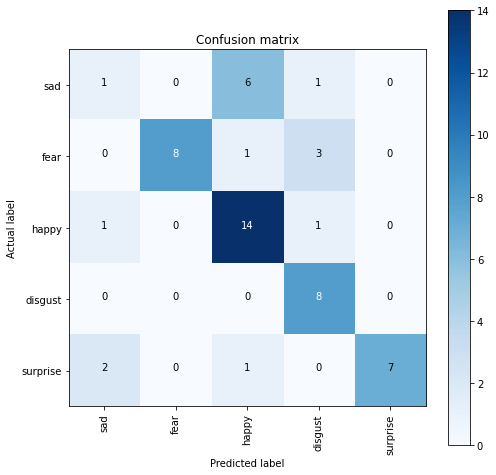

In [23]:
from sklearn.metrics import confusion_matrix

labels = list(set(test_label))
cm = confusion_matrix(test_label, predict, labels=labels)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, labels)

In [24]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(test_label, predict)
print('Accuracy: %0.3f' % total_acc)
print()

ccr = [cm[i, i] / cm[i, :].sum() for i in range(5)]
labels = list(set(test_label))
for i, l in enumerate(labels):
    print('CCR-%s: %0.3f' % (l, ccr[i]))

Accuracy: 0.644

CCR-sad: 0.125
CCR-fear: 0.667
CCR-happy: 0.875
CCR-disgust: 1.000
CCR-surprise: 0.700


In [25]:
from sklearn.metrics import confusion_matrix

labels = list(set(test_label))

ccrs = {l:[] for l in labels}

components = range(1, 155, 5)
for n in components:
    pca = PCA(n_components=n, random_state=123).fit(train_data)
    
    train_data_trans = pca.transform(train_data)
    test_data_trans = pca.transform(test_data)
    
    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(train_data_trans, train_label)
    predict = nn.predict(test_data_trans)

    cm = confusion_matrix(test_label, predict, labels=labels)
    ccr = [cm[i, i] / cm[i, :].sum() for i in range(5)]
    for i, l in enumerate(labels):
        ccrs[l].append(ccr[i])

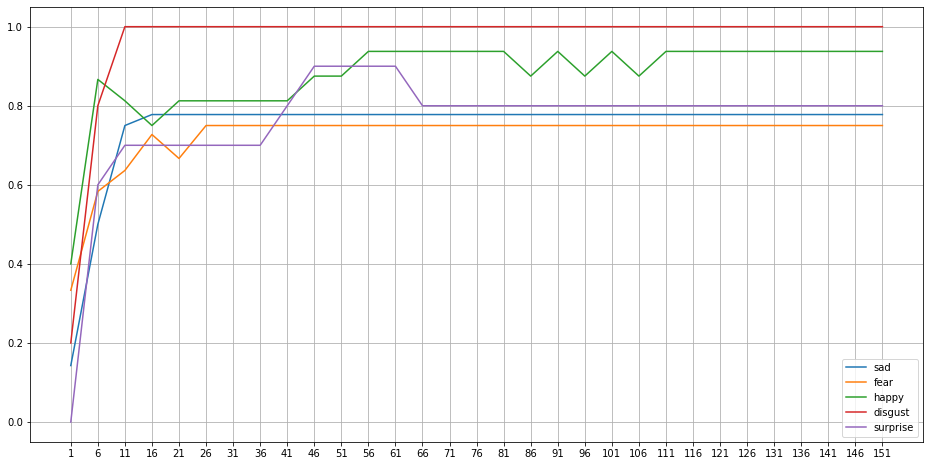

In [28]:
plt.figure(figsize=(16, 8))

for l in labels:
    plt.plot(components, ccrs[l], label=l)
plt.xticks(components)

plt.grid()
plt.legend()
plt.show()